In [1]:
import xarray as xr
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from skimage import exposure
from PVGeo.model_build import OutlineContinents

In [2]:
# From https://github.com/jobar8/graphics
import graphics

In [3]:
# These datasets are too big for VTKjs/panel
pv.rcParams['use_panel'] = False
pv.rcParams['nb_backend'] = False

# Gloabal Magnetic Data

*NOTE: For interactive visualizations, run this locally and change the `notebook=True` arguments to `notebook=False`.*

Special requirements:

- `PVGeo>=2.0.2`: `pip install -U PVGeo>=2.0.2`
- `graphics` from https://github.com/jobar8/graphics (copy/paste `graphics.py` and `colors.py` to new files next to this notebook)

Otherwise any somewhat recent version of the modules imported above should be fine.

In [4]:
RADIUS = 5380

continents = OutlineContinents(radius=RADIUS+20).apply()
continents

PolyData (0x13d722588)
  N Cells:	354
  N Points:	1028
  X Bounds:	-4.600e+03, 5.377e+03
  Y Bounds:	-5.328e+03, 5.351e+03
  Z Bounds:	-5.382e+03, 5.365e+03
  N Arrays:	0

In [5]:
def project_to_sphere(mesh, scalar_name='data'):
    """Projects the mesh's points inplace. If a scalar array
    is specified, then it will be used to distort/warp the points.
    """
    radius = RADIUS
    if isinstance(scalar_name, str):
        values = mesh.point_arrays[scalar_name]
        radius = (radius + (values) / 20)
        radius[np.isnan(radius)] = RADIUS
    phi = mesh.points[:,1]
    theta = mesh.points[:, 0]
    x = radius * np.cos(np.deg2rad(phi)) * np.cos(np.deg2rad(theta))
    y = radius * np.cos(np.deg2rad(phi)) * np.sin(np.deg2rad(theta))
    z = radius * np.sin(np.deg2rad(phi))
    mesh.points = np.vstack((x, y, z)).T
    return


def read(filename, scalar_name='data'):
    """Reads a TIFF image of Global Magnetic data."""
    dataset = xr.open_rasterio(filename)
    x, y = dataset['x'], dataset['y']
    z = [0,]
    mesh = pv.StructuredGrid(*np.meshgrid(x, y, z))
    # Grab the first band (index zero)
    mesh[scalar_name] = dataset.data[0,:,:].ravel(order="F")
    nans = mesh[scalar_name] == dataset.nodatavals
    mesh[scalar_name][nans] = np.nan
    # BROKEN: mesh[scalar_name] = np.ma.masked_where(nans, mesh[scalar_name])
    project_to_sphere(mesh, scalar_name=scalar_name)
    return mesh

In [6]:
def generate_equalized_cmap(values, vmin, vmax, cmap='Spectral_r'):
    with np.errstate(invalid='ignore'):
        cdf, bins = exposure.cumulative_distribution(
                (values[(values < vmax) *
                (values > vmin)]), nbins=256
        )

    cmap = graphics.equalizeColormap(cmap, bins, cdf)
    return cmap, cdf, bins

## EMAGv2

http://geomag.colorado.edu/images/EMAG2/EMAG2_V2.tif

In [7]:
emagv2 = read('./data/EMAG2_V2.tif')
emagv2

StructuredGrid (0x142f8cf48)
  N Cells:	58320000
  N Points:	58336201
  X Bounds:	-5.398e+03, 5.392e+03
  Y Bounds:	-5.402e+03, 5.392e+03
  Z Bounds:	-5.385e+03, 5.415e+03
  N Arrays:	1

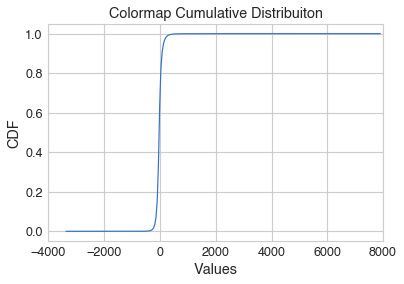

In [8]:
vmin, vmax = -4000, 8000
cmap, cdf, bins = generate_equalized_cmap(emagv2['data'], vmin, vmax)

plt.title('Colormap Cumulative Distribuiton')
plt.plot(bins, cdf)
plt.ylabel('CDF')
plt.xlabel('Values')
plt.xlim([vmin, vmax])
plt.show()

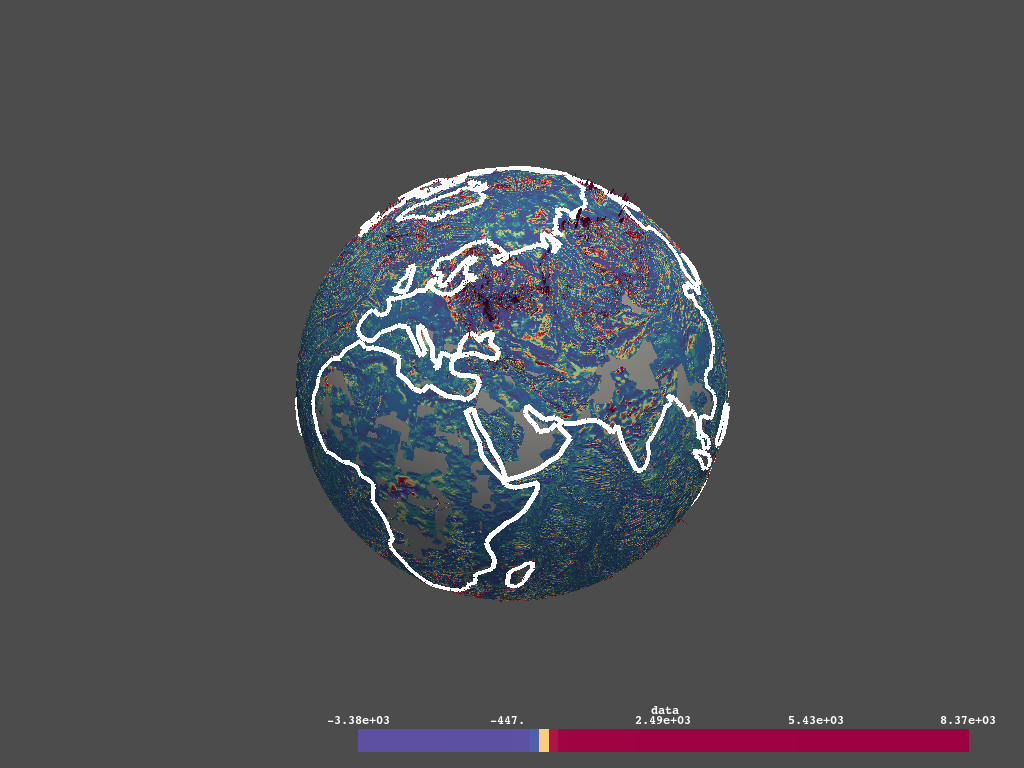

In [9]:
# Display in 3D
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(emagv2, cmap=cmap)
plotter.add_mesh(continents, color='w', line_width=5)
plotter.show()

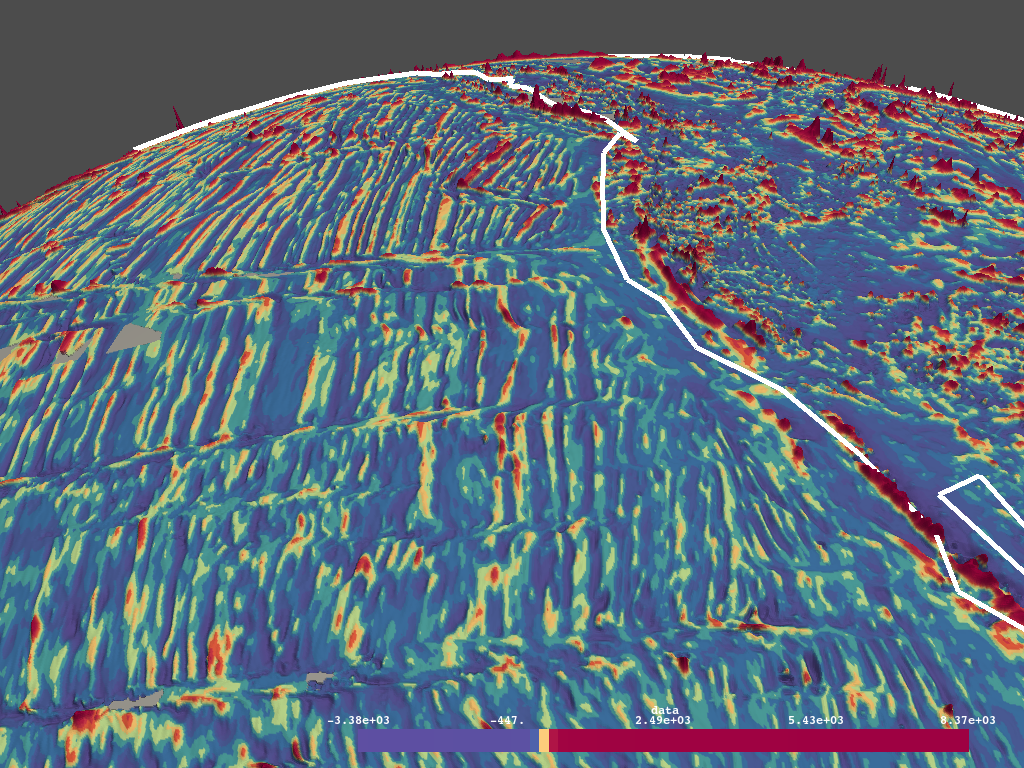

In [10]:
# Zoom into the West coast of the US
west_coast_us = [(-4469.179821695976, -6529.310239178578, 2333.0554710292117),
 (-508.667549770056, 78.32264131736054, 3896.9801778613282),
 (-0.11121417003071381, -0.1652804200591154, 0.9799560148952923)]
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(emagv2, cmap=cmap)
plotter.add_mesh(continents, color='w', line_width=5)
plotter.camera_position = west_coast_us
plotter.show()

## EMAGv3

https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_UpCont_DataTiff.tif

In [11]:
emagv3 = read('./data/EMAG2_V3_UpCont_DataTiff.tif')
emagv3

StructuredGrid (0x144080768)
  N Cells:	58293002
  N Points:	58309200
  X Bounds:	-5.396e+03, 5.386e+03
  Y Bounds:	-5.390e+03, 5.387e+03
  Z Bounds:	-5.395e+03, 5.516e+03
  N Arrays:	1

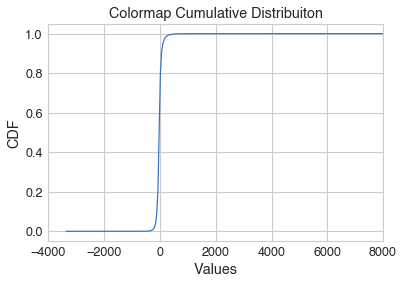

In [12]:
vmin, vmax = -4000, 8000
cmap, cdf, bins = generate_equalized_cmap(emagv3['data'], vmin, vmax)

plt.title('Colormap Cumulative Distribuiton')
plt.plot(bins, cdf)
plt.ylabel('CDF')
plt.xlabel('Values')
plt.xlim([vmin, vmax])
plt.show()

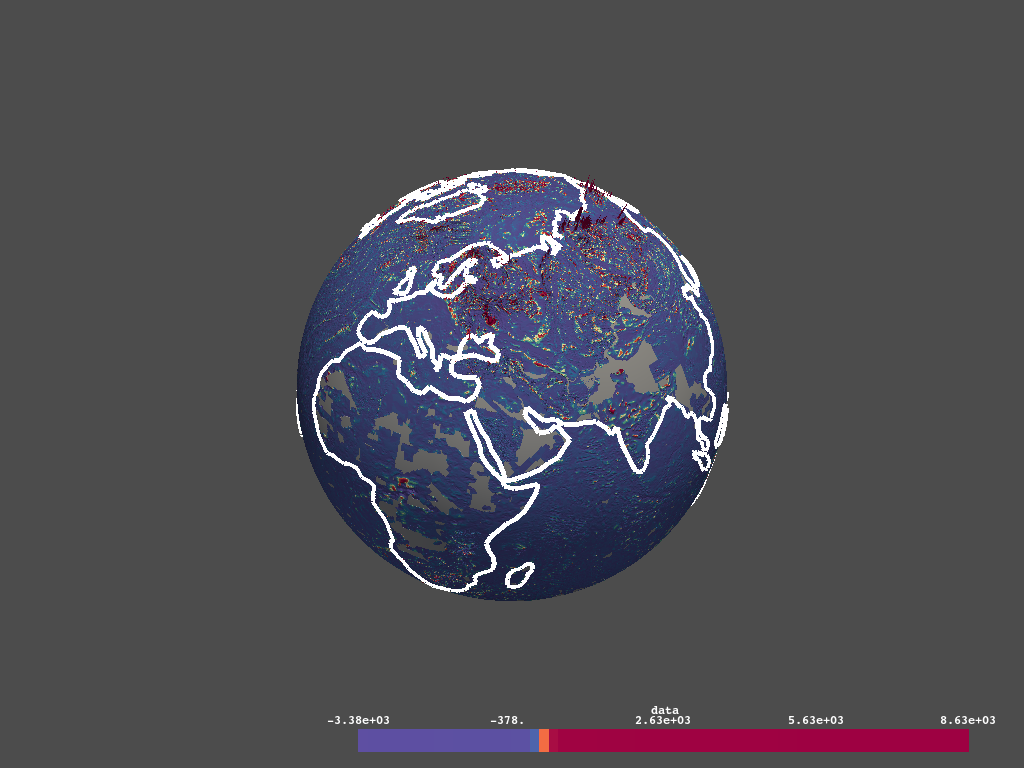

In [13]:
# Display in 3D
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(emagv3, cmap=cmap)
plotter.add_mesh(continents, color='w', line_width=5)
plotter.show()

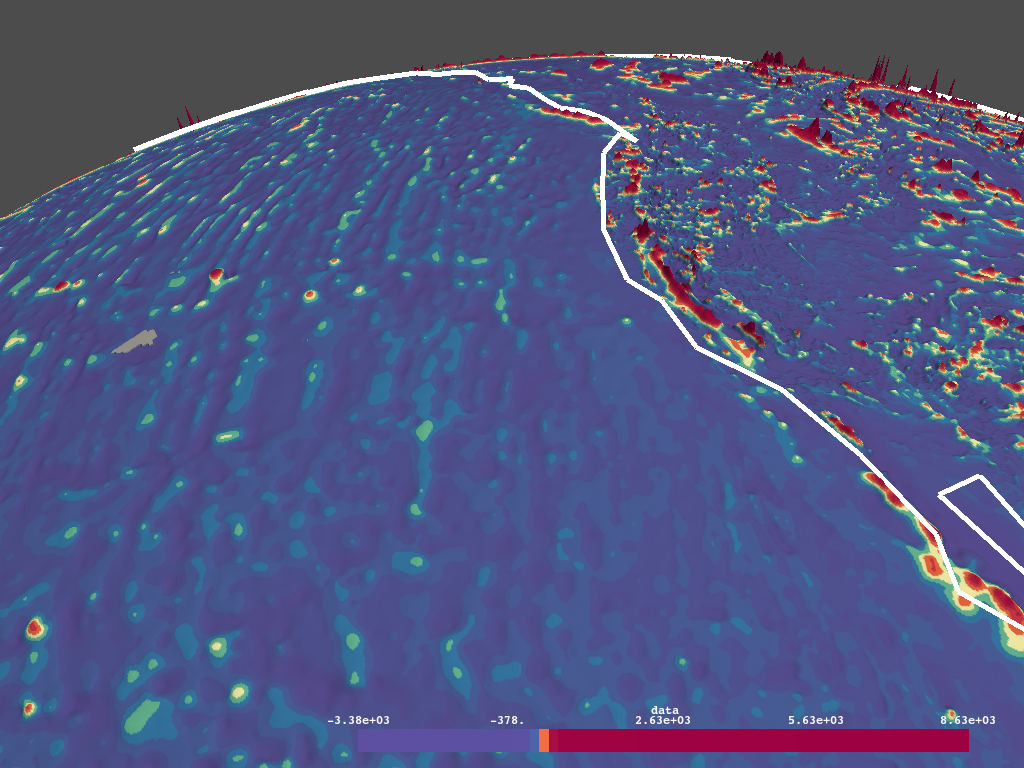

In [14]:
# Zoom into the West coast of the US
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(emagv3, cmap=cmap)
plotter.add_mesh(continents, color='w', line_width=5)
plotter.camera_position = west_coast_us
plotter.show()